In [19]:
import os
import matplotlib
import numpy as np
import pandas as pd
from dfply import *
from datetime import datetime
import matplotlib.pyplot as plt
from ChainLadder import ChainLadder

In [2]:
# 환경설정
pd.options.display.float_format = '{:,.0f}'.format
matplotlib.rc('font', family='Malgun Gothic', size=10)
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 불러오기
일반_원수_배상_계약 = pd.read_excel('./data/일반_원수_배상_계약.xlsx', \
              dtype={'CLG_YM': str, 'CTC_UY_YM': str, 'PDGR_CD': str, 'PDC_CD': str, 'WNCR_PRM': float, 'ELP_PRM': float})
일반_원수_배상_보상 = pd.read_excel('./data/일반_원수_배상_보상.xlsx', \
             dtype={'CLG_YM': str, 'CTC_UY_YM': str, 'ACCD_YM': str, 'PDGR_CD': str, 'PDC_CD': str, 'OGL_BNF': float, 'OST_AMT': float, 'ACCD_IVMT': float})
일반_상품코드 = pd.read_excel('./data/일반_상품코드.xlsx', \
            dtype={'PDC_CD': str})

In [4]:
# 전처리
일반_원수_배상_계약_전처리 = 일반_원수_배상_계약 >> mask(X.CTC_UY_YM <= '201812') \
    >> mutate(FY=X.CLG_YM.str.slice(0, 4)) \
    >> mutate(UY=X.CTC_UY_YM.str.slice(0, 4)) \
    >> left_join(일반_상품코드, on='PDC_CD')
일반_원수_배상_보상_전처리 = 일반_원수_배상_보상 >> mask(X.CTC_UY_YM <= '201812') \
    >> mutate(LOSS=X.OGL_BNF+X.OST_AMT+X.ACCD_IVMT) \
    >> mutate(FY=X.CLG_YM.str.slice(0, 4)) \
    >> mutate(UY=X.CTC_UY_YM.str.slice(0, 4)) \
    >> mutate(AY=X.ACCD_YM.str.slice(0, 4)) \
    >> mutate(DY=(X.FY.astype(int)-X.AY.astype(int)+1).astype(str)) \
    >> left_join(일반_상품코드, on='PDC_CD')

### Ⅰ. 배상책임보험 분석

#### 1. 경과보험료 규모

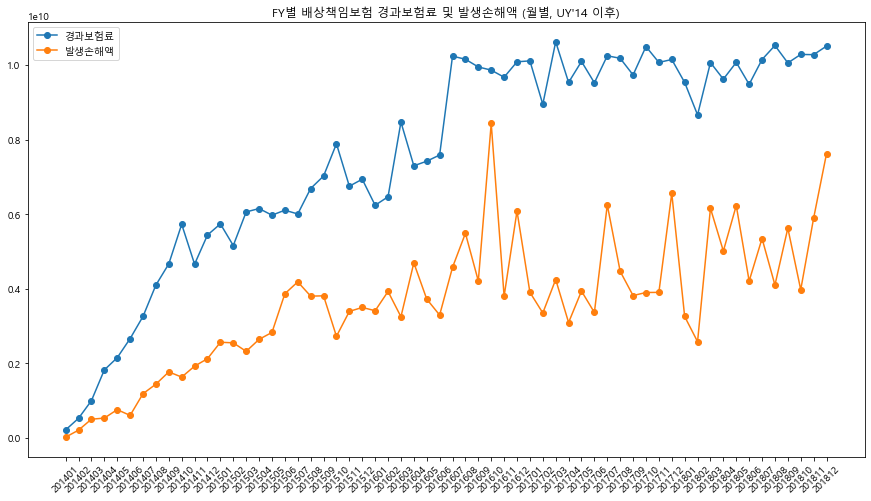

In [51]:
# FY별 배상책임보험 경과보험료 및 발생손해액 현황 (월별, UY'14 이후)
일반_원수_배상_계약_월집계 = 일반_원수_배상_계약_전처리 >> group_by(X.CLG_YM) \
    >> summarise(ELP_PRM=np.sum(X.ELP_PRM), WNCR_PRM=np.sum(X.WNCR_PRM))

일반_원수_배상_보상_월집계 = 일반_원수_배상_보상_전처리 >> group_by(X.CLG_YM) \
    >> summarise(LOSS=np.sum(X.LOSS))

일반_원수_배상_월집계 = 일반_원수_배상_계약_월집계 >> left_join(일반_원수_배상_보상_월집계, on='CLG_YM') \
    >> mutate(LOSS=if_else(X.LOSS.isna(), 0, X.LOSS)) \
    >> mutate(LOSS_RATIO=X.LOSS/X.ELP_PRM) \
    >> mutate(PROFIT=X.ELP_PRM-X.LOSS)

plt.figure(figsize=(15, 8))
plt.plot(일반_원수_배상_월집계['CLG_YM'], 일반_원수_배상_월집계['ELP_PRM'], '-o', label='경과보험료')
# plt.plot(일반_원수_배상_계약_FY집계['CLG_YM'], 일반_원수_배상_계약_FY집계['WNCR_PRM'], '-o', label='수입보험료')
plt.plot(일반_원수_배상_월집계['CLG_YM'], 일반_원수_배상_월집계['LOSS'], '-o', label='발생손해액')
# plt.plot(일반_원수_배상_월집계['CLG_YM'], 일반_원수_배상_월집계['PROFIT'], '-o', label='손익')
plt.xticks(rotation=45)
plt.legend()
plt.title('FY별 배상책임보험 경과보험료 및 발생손해액 (월별, UY\'14 이후)')
plt.show()

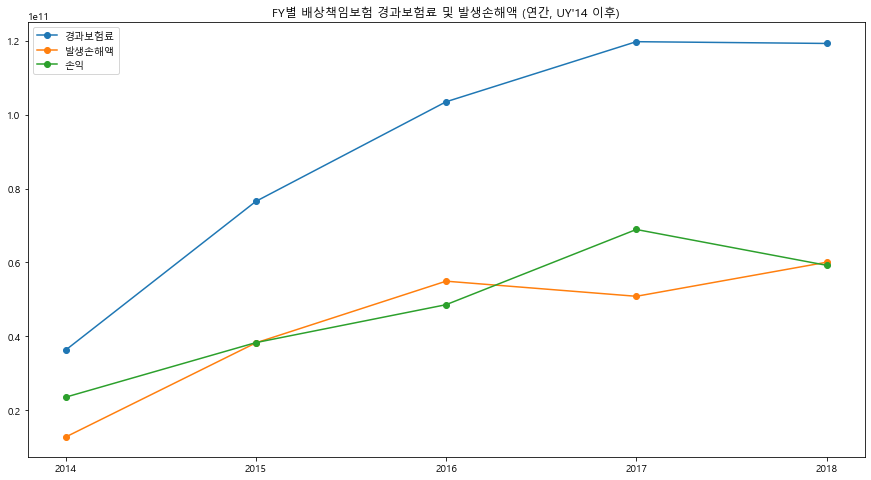

In [6]:
# FY별 배상책임보험 경과보험료 및 발생손해액 현황 (연간, UY'14 이후)
일반_원수_배상_계약_FY집계 = 일반_원수_배상_계약_전처리 >> group_by(X.FY) \
    >> summarise(ELP_PRM=np.sum(X.ELP_PRM), WNCR_PRM=np.sum(X.WNCR_PRM))

일반_원수_배상_보상_FY집계 = 일반_원수_배상_보상_전처리 >> group_by(X.FY) \
    >> summarise(LOSS=np.sum(X.LOSS))

일반_원수_배상_FY집계 = 일반_원수_배상_계약_FY집계 >> left_join(일반_원수_배상_보상_FY집계, on='FY') \
    >> mutate(LOSS=if_else(X.LOSS.isna(), 0, X.LOSS)) \
    >> mutate(LOSS_RATIO=X.LOSS/X.ELP_PRM) \
    >> mutate(PROFIT=X.ELP_PRM-X.LOSS)

plt.figure(figsize=(15, 8))
plt.plot(일반_원수_배상_FY집계['FY'], 일반_원수_배상_FY집계['ELP_PRM'], '-o', label='경과보험료')
# plt.plot(일반_원수_배상_계약_FY집계['FY'], 일반_원수_배상_계약_FY집계['WNCR_PRM'], '-o', label='수입보험료')
plt.plot(일반_원수_배상_FY집계['FY'], 일반_원수_배상_FY집계['LOSS'], '-o', label='발생손해액')
plt.plot(일반_원수_배상_FY집계['FY'], 일반_원수_배상_FY집계['PROFIT'], '-o', label='손익')
# plt.xticks(rotation=45)
plt.legend()
plt.title('FY별 배상책임보험 경과보험료 및 발생손해액 (연간, UY\'14 이후)')
plt.show()

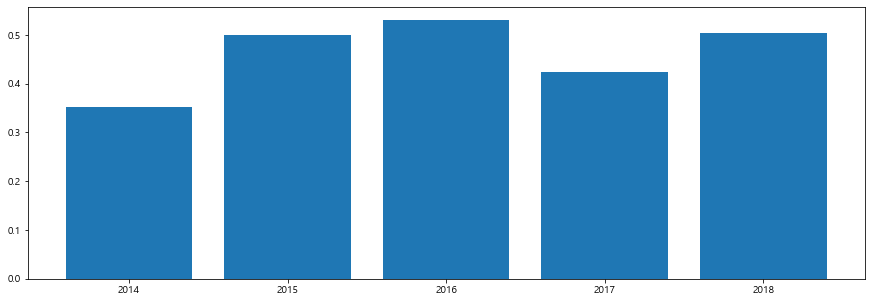

In [7]:
# 손해율
plt.figure(figsize=(15, 5))
plt.bar(일반_원수_배상_FY집계['FY'], 일반_원수_배상_FY집계['LOSS_RATIO'], label='손해율')
plt.show()

#### 2. 경과보험료 비중

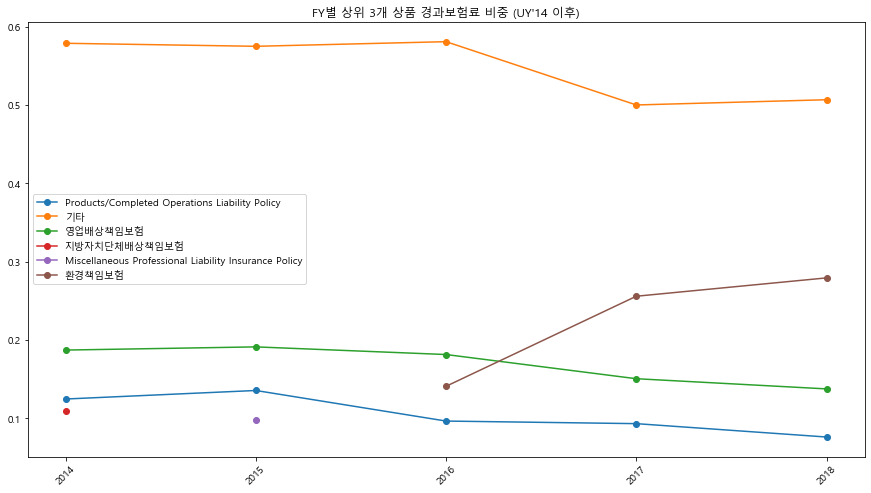

In [8]:
# FY별 배상책임보험 경과보험료 비중 (연간, UY'14 이후)
일반_원수_배상_계약_상품별비중 = 일반_원수_배상_계약_전처리.groupby(['PDC_NM', 'FY'])[['ELP_PRM']].sum().reset_index() \
    .set_index('PDC_NM').groupby('FY').apply(lambda df: df['ELP_PRM']/df['ELP_PRM'].sum()).reset_index() \
    .sort_values(by=['PDC_NM', 'FY'])
일반_원수_배상_계약_상품별비중 = 일반_원수_배상_계약_상품별비중 >> rename(ELP_PRM_WGT=X.ELP_PRM)
tmp = 일반_원수_배상_계약_상품별비중.groupby(['FY']).apply(lambda df: df.sort_values(by='ELP_PRM_WGT', ascending=False).head(3)['PDC_NM']).reset_index().drop('level_1', axis=1) \
    >> mutate(REP='O')
일반_원수_배상_계약_상품별비중 = 일반_원수_배상_계약_상품별비중 >> left_join(tmp, on=['FY', 'PDC_NM']) \
    >> mutate(REP=if_else(X.REP.isna(), 'X', X.REP)) \
    >> mutate(PDC_NM=if_else(X.REP == 'X', '기타', X.PDC_NM)) \
    >> drop(X.REP) \
    >> group_by('FY', 'PDC_NM') \
    >> summarise(ELP_PRM_WGT=np.sum(X.ELP_PRM_WGT))

plt.figure(figsize=(15, 8))
PDC_NM_TOTAL = 일반_원수_배상_계약_상품별비중['PDC_NM'].unique()
for PDC_NM in PDC_NM_TOTAL:
    tmp = 일반_원수_배상_계약_상품별비중.query('PDC_NM == @PDC_NM')
    plt.plot(tmp['FY'], tmp['ELP_PRM_WGT'], '-o', label=PDC_NM)    
plt.xticks(rotation=45)
plt.legend()
plt.title('FY별 상위 3개 상품 경과보험료 비중 (UY\'14 이후)')
plt.show()

#### 3. IBNR 및 손해율 예측

In [9]:
triangle = 일반_원수_배상_보상_전처리.query('AY >= "2014"').groupby(['AY', 'DY'])['LOSS'].sum().reset_index() \
    .pivot_table(index='AY', columns='DY', aggfunc=np.sum)
cl = ChainLadder(triangle, type='incr')
development_factor = cl.dev_factor('weighted average', 1.139735225)
ibnr = cl.reserve(development_factor)['Reserve'].sum()

loss = 일반_원수_배상_보상_전처리['LOSS'].sum()
elp_prm = 일반_원수_배상_계약_전처리['ELP_PRM'].sum()

loss_ratio = (loss+ibnr)/elp_prm
print('경과보험료: {:,.0f}억원\n발생손해액: {:,.0f}억원 (IBNR: {:,.0f}억원)\n손해율: {}%'.format(np.round(elp_prm/1e8), np.round((loss+ibnr)/1e8), np.round(ibnr/1e8), np.round(loss_ratio*100,1)))

경과보험료: 4,554억원
발생손해액: 3,120억원 (IBNR: 952억원)
손해율: 68.5%


### Ⅱ. 배상책임보험 유사상품 분석

#### 1. 상품목록 및 유사상품 선정

In [10]:
print(일반_원수_배상_계약_전처리.PDC_NM.unique())

['체육시설업자배상책임보험' '낚시업자배상책임보험' '적재물배상책임보험' '어린이놀이시설배상책임보험' '기업포괄배상책임보험'
 'Miscellaneous Professional Liability Insurance Policy' '생산물배상책임보험'
 '의사및병원배상책임보험' '변호사배상책임보험' '수련시설배상책임보험' '영업배상책임공제보험' '전자금융거래배상책임보험'
 'Products/Completed Operations Liability Policy' '학원배상책임보험'
 'Commercial General Liability' '영업배상책임보험' '임원배상책임보험' '사회복무요원보상책임보험'
 'Financial Institution Professional Indemnity Policy' '유도선사업자배상책임보험'
 '가스사고배상책임보험' '참스승배상책임보험' '생산물배상책임보험(중소기업중앙회용)' '선주배상책임보험'
 '다중이용업소화재배상책임보험' '지방자치단체배상책임보험' '설계감리등용역손해배상보험' '회계사배상책임보험'
 "Lottery Manufacturer's & Contractor's Liability Policy" '엔지니어링손해배상책임보험'
 '컴퓨터소프트웨어사업자배상책임보험' '개인정보누출배상책임보험' '청소년활동배상책임보험' '건설기계업자배상책임보험'
 '도급업자배상책임보험' '전문직업인배상책임보험' "Credit Card Manufacturer's Liability Policy"
 'Aircraft Refueling Liability Insurance Policy' '보험중개인배상책임보험'
 '다중이용업소화재배상책임보험(공제용)' '사회복지시설배상책임보험Ⅱ' '사회복지시설배상책임보험' '태양광대여사업자배상책임보험'
 '인증설비손해배상보험' '환경책임보험' '환경오염배상책임보험' 'Cyber Security Policy' '재난배상책임보험'
 '지방자치단체업무배상책임보험' '지방자치단체공무원배상책임보험'
 'Principal Control

In [11]:
PDC_NM_SELECTED = np.array(['참스승배상책임보험', '사회복무요원보상책임보험', '사회복지시설배상책임보험', '사회복지시설배상책임보험Ⅱ', '지방자치단체배상책임보험', '지방자치단체업무배상책임보험', '지방자치단체공무원배상책임보험'])
일반_원수_배상_계약_선택 = 일반_원수_배상_계약_전처리 >> mask(X.PDC_NM.isin(PDC_NM_SELECTED))
일반_원수_배상_보상_선택 = 일반_원수_배상_보상_전처리 >> mask(X.PDC_NM.isin(PDC_NM_SELECTED))
PDC_NM_SELECTED

array(['참스승배상책임보험', '사회복무요원보상책임보험', '사회복지시설배상책임보험', '사회복지시설배상책임보험Ⅱ',
       '지방자치단체배상책임보험', '지방자치단체업무배상책임보험', '지방자치단체공무원배상책임보험'], dtype='<U15')

#### 2. 유사상품비중

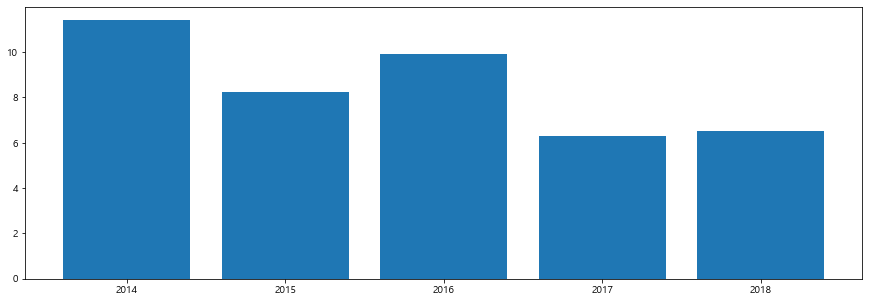

In [36]:
일반_원수_배상_계약_선택_비중 = 일반_원수_배상_계약_선택 >> group_by(X.FY) \
    >> summarise(ELP_PRM_SELECTED=np.sum(X.ELP_PRM), WNCR_PRM_SELECTED=np.sum(X.WNCR_PRM)) \
    >> left_join(일반_원수_배상_계약_FY집계, on='FY') \
    >> mutate(ELP_PRM_WGT=X.ELP_PRM_SELECTED/X.ELP_PRM*100)

# 유사상품비중
plt.figure(figsize=(15, 5))
plt.bar(일반_원수_배상_계약_선택_비중['FY'], 일반_원수_배상_계약_선택_비중['ELP_PRM_WGT'])
plt.show()

#### 3. 경과보험료 규모

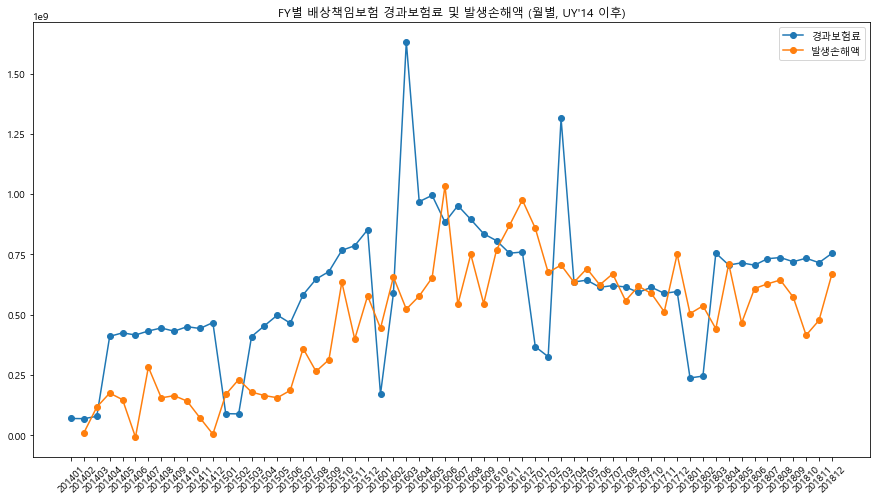

In [55]:
# FY별 배상책임보험 경과보험료 및 발생손해액 현황 (월별, UY'14 이후)
일반_원수_배상_계약_선택_월집계 = 일반_원수_배상_계약_선택 >> group_by(X.CLG_YM) \
    >> summarise(ELP_PRM=np.sum(X.ELP_PRM), WNCR_PRM=np.sum(X.WNCR_PRM))

일반_원수_배상_보상_선택_월집계 = 일반_원수_배상_보상_선택 >> group_by(X.CLG_YM) \
    >> summarise(LOSS=np.sum(X.LOSS))

일반_원수_배상_선택_월집계 = 일반_원수_배상_계약_선택_월집계 >> left_join(일반_원수_배상_보상_선택_월집계, on='CLG_YM') \
    >> mutate(LOSS=if_else(X.LOSS.isna(), 0, X.LOSS)) \
    >> mutate(LOSS_RATIO=X.LOSS/X.ELP_PRM) \
    >> mutate(PROFIT=X.ELP_PRM-X.LOSS)

plt.figure(figsize=(15, 8))
plt.plot(일반_원수_배상_계약_선택_월집계['CLG_YM'], 일반_원수_배상_계약_선택_월집계['ELP_PRM'], '-o', label='경과보험료')
# plt.plot(일반_원수_배상_계약_FY집계['CLG_YM'], 일반_원수_배상_계약_FY집계['WNCR_PRM'], '-o', label='수입보험료')
plt.plot(일반_원수_배상_보상_선택_월집계['CLG_YM'], 일반_원수_배상_보상_선택_월집계['LOSS'], '-o', label='발생손해액')
plt.xticks(rotation=45)
plt.legend()
plt.title('FY별 배상책임보험 경과보험료 및 발생손해액 (월별, UY\'14 이후)')
plt.show()

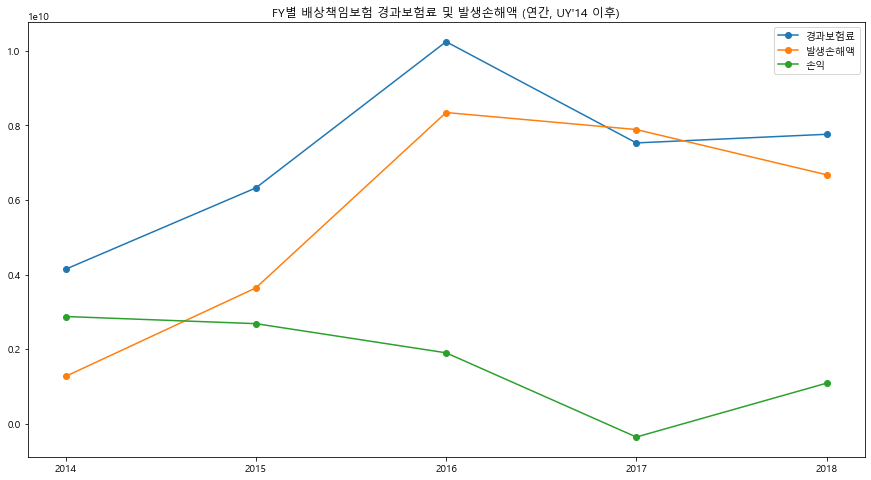

In [14]:
# FY별 배상책임보험 경과보험료 및 발생손해액 현황 (연간, UY'14 이후)
일반_원수_배상_계약_선택_FY집계 = 일반_원수_배상_계약_선택 >> group_by(X.FY) \
    >> summarise(ELP_PRM=np.sum(X.ELP_PRM), WNCR_PRM=np.sum(X.WNCR_PRM))

일반_원수_배상_보상_선택_FY집계 = 일반_원수_배상_보상_선택 >> group_by(X.FY) \
    >> summarise(LOSS=np.sum(X.LOSS))

일반_원수_배상_선택_FY집계 = 일반_원수_배상_계약_선택_FY집계 >> left_join(일반_원수_배상_보상_선택_FY집계, on='FY') \
    >> mutate(LOSS=if_else(X.LOSS.isna(), 0, X.LOSS)) \
    >> mutate(LOSS_RATIO=X.LOSS/X.ELP_PRM) \
    >> mutate(PROFIT=X.ELP_PRM-X.LOSS)

plt.figure(figsize=(15, 8))
plt.plot(일반_원수_배상_선택_FY집계['FY'], 일반_원수_배상_선택_FY집계['ELP_PRM'], '-o', label='경과보험료')
# plt.plot(일반_원수_배상_계약_FY집계['FY'], 일반_원수_배상_계약_FY집계['WNCR_PRM'], '-o', label='수입보험료')
plt.plot(일반_원수_배상_선택_FY집계['FY'], 일반_원수_배상_선택_FY집계['LOSS'], '-o', label='발생손해액')
plt.plot(일반_원수_배상_선택_FY집계['FY'], 일반_원수_배상_선택_FY집계['PROFIT'], '-o', label='손익')
# plt.xticks(rotation=45)
plt.legend()
plt.title('FY별 배상책임보험 경과보험료 및 발생손해액 (연간, UY\'14 이후)')
plt.show()

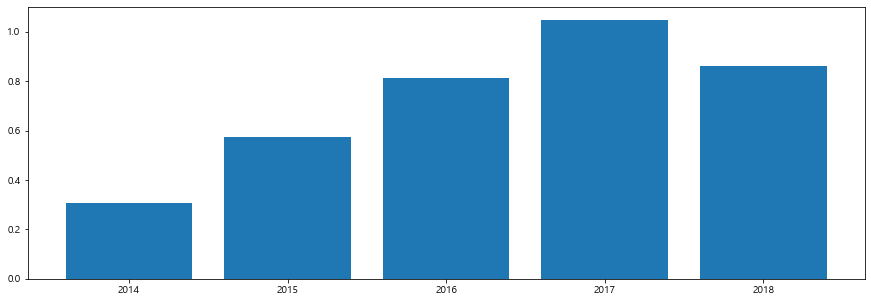

In [15]:
# 손해율
plt.figure(figsize=(15, 5))
plt.bar(일반_원수_배상_선택_FY집계['FY'], 일반_원수_배상_선택_FY집계['LOSS_RATIO'], label='손해율')
plt.show()

#### 4. 경과보험료 비중

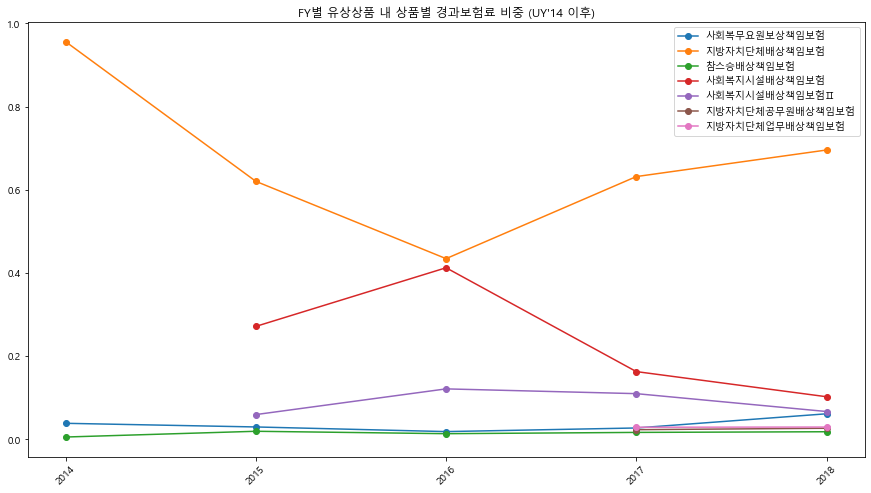

In [16]:
# FY별 배상책임보험 경과보험료 비중 (연간, UY'14 이후)
일반_원수_배상_계약_선택_상품별비중 = 일반_원수_배상_계약_선택.groupby(['PDC_NM', 'FY'])[['ELP_PRM']].sum().reset_index() \
    .set_index('PDC_NM').groupby('FY').apply(lambda df: df['ELP_PRM']/df['ELP_PRM'].sum()).reset_index() \
    .sort_values(by=['PDC_NM', 'FY'])
일반_원수_배상_계약_선택_상품별비중 = 일반_원수_배상_계약_선택_상품별비중 >> rename(ELP_PRM_WGT=X.ELP_PRM)
tmp = 일반_원수_배상_계약_선택_상품별비중.groupby(['FY']).apply(lambda df: df.sort_values(by='ELP_PRM_WGT', ascending=False)['PDC_NM']).reset_index().drop('level_1', axis=1) \
    >> mutate(REP='O')
일반_원수_배상_계약_선택_상품별비중 = 일반_원수_배상_계약_선택_상품별비중 >> left_join(tmp, on=['FY', 'PDC_NM']) \
    >> mutate(REP=if_else(X.REP.isna(), 'X', X.REP)) \
    >> mutate(PDC_NM=if_else(X.REP == 'X', '기타', X.PDC_NM)) \
    >> drop(X.REP) \
    >> group_by('FY', 'PDC_NM') \
    >> summarise(ELP_PRM_WGT=np.sum(X.ELP_PRM_WGT))

plt.figure(figsize=(15, 8))
PDC_NM_TOTAL = 일반_원수_배상_계약_선택_상품별비중['PDC_NM'].unique()
for PDC_NM in PDC_NM_TOTAL:
    tmp = 일반_원수_배상_계약_선택_상품별비중.query('PDC_NM == @PDC_NM')
    plt.plot(tmp['FY'], tmp['ELP_PRM_WGT'], '-o', label=PDC_NM)    
plt.xticks(rotation=45)
plt.legend()
plt.title('FY별 유상상품 내 상품별 경과보험료 비중 (UY\'14 이후)')
plt.show()

#### 5. IBNR 및 손해율 예측

In [17]:
triangle_selected = 일반_원수_배상_보상_선택.query('AY >= "2014"').groupby(['AY', 'DY'])['LOSS'].sum().reset_index() \
    .pivot_table(index='AY', columns='DY', aggfunc=np.sum)
cl_selected = ChainLadder(triangle_selected, type='incr')
development_factor_selected = cl_selected.dev_factor('weighted average', 1.02391165)
ibnr_selected = cl_selected.reserve(development_factor_selected)['Reserve'].sum()

loss_selected = 일반_원수_배상_보상_선택['LOSS'].sum()
elp_prm_selected = 일반_원수_배상_계약_선택['ELP_PRM'].sum()

loss_ratio_selected = (loss_selected+ibnr_selected)/elp_prm_selected
print('경과보험료: {:,.0f}억원\n발생손해액: {:,.0f}억원 (IBNR: {:,.0f}억원)\n손해율: {}%'.format(np.round(elp_prm_selected/1e8), np.round((loss_selected+ibnr_selected)/1e8), np.round(ibnr_selected/1e8), np.round(loss_ratio_selected*100,1)))

경과보험료: 360억원
발생손해액: 335억원 (IBNR: 56억원)
손해율: 92.9%


In [87]:
# 예측
prediction = pd.DataFrame([ibnr, loss_ratio, ibnr_selected, loss_ratio_selected]).T
prediction.columns = ['전체_IBNR', '전체_예측손해율', '유사상품_IBNR', '유사상품_예측손해율']
prediction

,전체_IBNR,전체_예측손해율,유사상품_IBNR,유사상품_예측손해율
0,"95,197,991,299",1,"5,632,347,802",1


In [88]:
# 출력
if not any([s == 'result' for s in os.listdir('.')]):
    os.mkdir('result')
    
now = datetime.now().strftime('%Y%m%d%H%M%S')
ver = 'v1.0'

with pd.ExcelWriter('./result/배상책임보험_{}_{}.xlsx'.format(ver, now)) as writer:
    일반_원수_배상_계약_전처리.PDC_NM.drop_duplicates().to_excel(writer, '배상책임보험', index=False)
    pd.DataFrame(PDC_NM_SELECTED, columns=['PDC_NM']).to_excel(writer, '유사상품', index=False)
    일반_원수_배상_월집계.to_excel(writer, '전체_월집계', index=False)
    일반_원수_배상_FY집계.to_excel(writer, '전체_FY집계', index=False)
    일반_원수_배상_선택_월집계.to_excel(writer, '유사상품_월집계', index=False)
    일반_원수_배상_선택_FY집계.to_excel(writer, '유사상품_FY집계', index=False)
    일반_원수_배상_계약_선택_비중.to_excel(writer, '유사상품_비중', index=False)
    cl.triangle_cum.to_excel(writer, '전체_진전추이')
    cl_selected.triangle_cum.to_excel(writer, '유사상품_진전추이')
    prediction.to_excel(writer, '예측', index=False)